In [1]:
# Import standard libraries
import os
import sys
import pathlib
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

# Setup paths (following pattern from other scratch notebooks)
_parent_dir = pathlib.Path(os.getcwd()).parent
_cymetric_dir = _parent_dir.parent / 'cymetric'
if str(_parent_dir) not in sys.path:
    sys.path.insert(0, str(_parent_dir))
if str(_cymetric_dir) not in sys.path:
    sys.path.insert(0, str(_cymetric_dir))

# Import cymetric with compatibility fix
import cymetric
if hasattr(cymetric, 'cymetric'):
    sys.modules['cymetric'] = cymetric.cymetric

# Import CyMetric components (NO TensorFlow yet!)
from cymetric.pointgen.pointgen import PointGenerator

# Import local geometry modules (NO TensorFlow yet!)
from geometry.patches import CoordChange_C5R10
from geometry.compression import form_to_vec, vec_to_form, metric_to_vec

print("✅ All imports successful (TensorFlow deferred until after point generation)")


✅ All imports successful (TensorFlow deferred until after point generation)


## 1. Load CY Model and Generate Data

In [2]:
# Set up paths
cymodel_name = ''  # Set to '_name' if using named model
parent_dir = os.path.dirname(os.getcwd())
dirname = os.path.join(parent_dir, 'models', 'cy_models', 'link_data')
config_path = os.path.join(parent_dir, f'models/cy_models/cy_model_config{cymodel_name}.yaml')
cymodel_path = os.path.join(parent_dir, f'models/cy_models/cy_metric_model{cymodel_name}.keras')

# Load configuration
with open(config_path, 'r') as f:
    config = yaml.unsafe_load(f)

print("Configuration loaded:")
print(f"  Monomials shape: {np.array(config['monomials']).shape}")
print(f"  Ambient dimension: {config['ambient']}")
print(f"  Neural network: {config['nlayer']} layers, {config['nHidden']} hidden units")


Configuration loaded:
  Monomials shape: (5, 5)
  Ambient dimension: [4]
  Neural network: 3 layers, 64 hidden units


In [ ]:
# Generate CY points
n_samples = 50000  # Number of samples to generate

print(f"Generating {n_samples} CY points...")

# Initialize point generator
pg = PointGenerator(
    config['monomials'], 
    config['coefficients'], 
    config['kmoduli'], 
    config['ambient']
)

# Generate dataset
kappa = pg.prepare_dataset(n_samples, dirname, val_split=0.)
pg.prepare_basis(dirname, kappa=kappa)

# Load generated data
data = np.load(os.path.join(dirname, 'dataset.npz'))
cy_points = data['X_train']

print(f"✅ Generated {len(cy_points)} CY points")
print(f"CY points shape: {cy_points.shape}")
print(f"Point dimensionality: {cy_points.shape[1]} (R^10 representation)")

# NOW import TensorFlow and load the model (after point generation to avoid worker conflicts)
print("\nImporting TensorFlow and loading CY model...")

import tensorflow as tf
from cymetric.models.tfhelper import prepare_tf_basis
from cymetric.models.tfmodels import PhiFSModel
from geometry.geometry import hermitian_to_kahler_real, compute_gG2, holomorphic_volume_form_to_real
from geometry.wedge import wedge
from sampling.sampling import LinkSample

# Load basis
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS_tf = prepare_tf_basis(BASIS)

# Build neural network architecture
nn_phi = tf.keras.Sequential()
nn_phi.add(tf.keras.Input(shape=(config['n_in'],)))
for _ in range(config['nlayer']):
    nn_phi.add(tf.keras.layers.Dense(config['nHidden'], activation=config['act']))
nn_phi.add(tf.keras.layers.Dense(config['n_out'], use_bias=False))

# Create PhiFSModel
cy_model = PhiFSModel(nn_phi, BASIS_tf, alpha=config['alpha'])

# Load pre-trained weights
cy_model.nn_phi = tf.keras.models.load_model(cymodel_path)

print(f"✅ CY model loaded successfully!")
print(f"Model path: {cymodel_path}")


Generating 50000 CY points...


pointgen:INFO:Vol_k: 5.000000000000001, Vol_cy: 283.77150717112346.


✅ Generated 50000 CY points
CY points shape: (50000, 10)
Point dimensionality: 10 (R^10 representation)

Importing TensorFlow and loading CY model...
✅ CY model loaded successfully!
Model path: /Users/ed/Documents/Projects/G2/Flows/G2Metric/github/models/cy_models/cy_metric_model.keras


## 2. Compute CY Geometric Quantities

In [4]:
# Compute holomorphic volume form and Hermitian metric on CY
print("Computing CY geometric quantities...")

# Convert to C^5 complex coordinates (needed for holomorphic volume form)
cy_points_C5 = CoordChange_C5R10(cy_points, inverse=True)

# Compute holomorphic volume form using PointGenerator
cy_omega = pg.holomorphic_volume_form(cy_points_C5)

# Compute Hermitian metric using the model (call model directly, not predict_g)
cy_g = cy_model(CoordChange_C5R10(cy_points_C5)).numpy()

print(f"Omega shape: {cy_omega.shape}")
print(f"Hermitian metric shape: {cy_g.shape}")

# Extract real and imaginary parts of Omega
cy_omega_real = np.real(cy_omega)
cy_omega_imag = np.imag(cy_omega)

# Hermitian metric is already real (6 complex components as 3x3 Hermitian matrix)
print(f"Omega real shape: {cy_omega_real.shape}")
print(f"Omega imag shape: {cy_omega_imag.shape}")


Computing CY geometric quantities...
Omega shape: (50000,)
Hermitian metric shape: (50000, 3, 3)
Omega real shape: (50000,)
Omega imag shape: (50000,)
Omega shape: (50000,)
Hermitian metric shape: (50000, 3, 3)
Omega real shape: (50000,)
Omega imag shape: (50000,)


## 3. Generate Link Samples and G2 Structure

In [ ]:
# Generate link samples from CY points
print(f"Generating link samples from {len(cy_points)} CY points...")

# Configuration: Set to True to also compute G2 metric (computationally expensive)
compute_g2_metric = False

# Sample random angles for each point
thetas = np.random.uniform(low=0., high=2*np.pi, size=len(cy_points_C5))

# Extract C^3 local coordinates (excluding one_idx and dropped_idx)
one_idxs = np.argmax(np.isclose(cy_points_C5, complex(1, 0)), axis=1)
dropped_idxs = pg._find_max_dQ_coords(cy_points_C5)

mask = np.ones(cy_points_C5.shape, dtype=bool)
samples = np.arange(cy_points_C5.shape[0])
mask[samples, one_idxs] = False
mask[samples, dropped_idxs] = False
c3_coords = cy_points_C5[mask].reshape(cy_points_C5.shape[0], -1)

# Link local coordinates: [Re(z1), Re(z2), Re(z3), Im(z1), Im(z2), Im(z3), theta]
link_local_coords = np.concatenate((np.real(c3_coords), np.imag(c3_coords), thetas.reshape(-1, 1)), axis=1)

# Compute link ambient coordinates in R^10
cy_points_on_S9 = cy_points_C5 / np.linalg.norm(cy_points_C5, axis=1).reshape(-1, 1)
link_points_C5 = cy_points_on_S9 * np.exp(1j * thetas.reshape(-1, 1))
link_ambient_coords = CoordChange_C5R10(link_points_C5)

# Compute G2 3-form
hvf_r, hvf_i = holomorphic_volume_form_to_real(cy_omega)
kahler_form_R6 = hermitian_to_kahler_real(cy_g)
kahler_form_R7 = np.pad(kahler_form_R6, ((0,0), (0,1), (0,1)), mode='constant')

dthetas = np.concatenate((np.zeros((len(cy_points_C5), 6)), np.ones((len(cy_points_C5), 1))), axis=1)
link_phi_G2 = np.array([wedge(kahler_form_R7[i], dthetas[i]) for i in range(len(cy_points_C5))])
link_phi_G2[:, :6, :6, :6] += hvf_r

# Compute G2 metric (optional, can be expensive)
if compute_g2_metric:
    print("Computing G2 metric (this may take a while)...")
    link_g_G2 = np.array([compute_gG2(phi) for phi in link_phi_G2])
    print(f"Link G2 metric shape: {link_g_G2.shape}")
else:
    link_g_G2 = None
    print("Skipping G2 metric computation (compute_g2_metric=False)")

print(f"Link local coords shape: {link_local_coords.shape}")
print(f"Link ambient coords shape: {link_ambient_coords.shape}")
print(f"Link G2 3-form shape: {link_phi_G2.shape}")


Generating link samples from 50000 CY points...
Skipping G2 metric computation (compute_g2_metric=False)
Link local coords shape: (50000, 7)
Link ambient coords shape: (50000, 10)
Link G2 3-form shape: (50000, 7, 7, 7)
Skipping G2 metric computation (compute_g2_metric=False)
Link local coords shape: (50000, 7)
Link ambient coords shape: (50000, 10)
Link G2 3-form shape: (50000, 7, 7, 7)


## 4. Convert to Input/Output Vectors for Analysis

We separate complex coordinates into real and imaginary parts for proper statistical analysis.

In [6]:
# CY COORDINATES
# Convert C^5 complex coordinates to real representation: 5 complex = 10 real
cy_coords_real = np.real(cy_points_C5)
cy_coords_imag = np.imag(cy_points_C5)
print(f"CY coordinates (real part) shape: {cy_coords_real.shape}")
print(f"CY coordinates (imag part) shape: {cy_coords_imag.shape}")

# CY LOCAL COORDINATES (C^3)
# Extract real and imaginary parts of the C^3 local coordinates
cy_local_real = np.real(c3_coords)
cy_local_imag = np.imag(c3_coords)
print(f"CY local coordinates (real part) shape: {cy_local_real.shape}")
print(f"CY local coordinates (imag part) shape: {cy_local_imag.shape}")

# CY HERMITIAN METRIC
# Convert Hermitian metric to vector form (use metric_to_vec for symmetric matrices)
# Note: metric_to_vec returns Cholesky decomposition, take real part for analysis
cy_g_vec = np.real(metric_to_vec(tf.convert_to_tensor(cy_g)).numpy())
print(f"CY Hermitian metric vector shape: {cy_g_vec.shape}")

# LINK COORDINATES
# Link ambient coordinates: C^5 complex = 10 real
link_coords_real = np.real(link_points_C5)
link_coords_imag = np.imag(link_points_C5)
print(f"Link ambient coordinates (real part) shape: {link_coords_real.shape}")
print(f"Link ambient coordinates (imag part) shape: {link_coords_imag.shape}")

# Link local coordinates: already has real/imag separated in link_local_coords (R^7)
# Extract the components: [Re(z1,z2,z3), Im(z1,z2,z3), theta]
link_local_real = link_local_coords[:, :3]  # Real parts of C^3
link_local_imag = link_local_coords[:, 3:6]  # Imaginary parts of C^3
link_theta = link_local_coords[:, 6:7]  # Angle theta
print(f"Link local coordinates (real part) shape: {link_local_real.shape}")
print(f"Link local coordinates (imag part) shape: {link_local_imag.shape}")
print(f"Link theta coordinate shape: {link_theta.shape}")

# LINK G2 3-FORM
# Convert G2 3-form to vector form (use form_to_vec for antisymmetric tensors)
link_phi_vec = np.real(form_to_vec(tf.convert_to_tensor(link_phi_G2)).numpy())
print(f"Link G2 3-form vector shape: {link_phi_vec.shape}")

# LINK G2 METRIC
# Convert G2 metric to vector form (use metric_to_vec for symmetric matrices)
if compute_g2_metric:
    link_g_vec = np.real(metric_to_vec(tf.convert_to_tensor(link_g_G2)).numpy())
    print(f"Link G2 metric vector shape: {link_g_vec.shape}")
else:
    link_g_vec = None
    print("Link G2 metric: Not computed")

CY coordinates (real part) shape: (50000, 5)
CY coordinates (imag part) shape: (50000, 5)
CY local coordinates (real part) shape: (50000, 3)
CY local coordinates (imag part) shape: (50000, 3)
CY Hermitian metric vector shape: (50000, 6)
Link ambient coordinates (real part) shape: (50000, 5)
Link ambient coordinates (imag part) shape: (50000, 5)
Link local coordinates (real part) shape: (50000, 3)
Link local coordinates (imag part) shape: (50000, 3)
Link theta coordinate shape: (50000, 1)
Link G2 3-form vector shape: (50000, 35)
Link G2 metric: Not computed


## 5. Statistical Analysis Functions

In [7]:
def compute_statistics(data, name):
    """Compute comprehensive statistics for a dataset."""
    stats_dict = {
        'name': name,
        'shape': data.shape,
        'mean': np.mean(data),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'median': np.median(data),
        'q25': np.percentile(data, 25),
        'q75': np.percentile(data, 75),
        'skewness': stats.skew(data.flatten()),
        'kurtosis': stats.kurtosis(data.flatten()),
        'sparsity': np.sum(np.abs(data) < 1e-6) / data.size * 100,  # % near-zero
        'zero_fraction': np.sum(data == 0) / data.size * 100,  # % exactly zero
    }
    return stats_dict

def print_statistics(stats_dict):
    """Pretty print statistics."""
    print(f"\n{'='*60}")
    print(f"Statistics for: {stats_dict['name']}")
    print(f"{'='*60}")
    print(f"Shape:           {stats_dict['shape']}")
    print(f"Mean:            {stats_dict['mean']:.6f}")
    print(f"Std:             {stats_dict['std']:.6f}")
    print(f"Min:             {stats_dict['min']:.6f}")
    print(f"Max:             {stats_dict['max']:.6f}")
    print(f"Median:          {stats_dict['median']:.6f}")
    print(f"Q25-Q75:         [{stats_dict['q25']:.6f}, {stats_dict['q75']:.6f}]")
    print(f"Skewness:        {stats_dict['skewness']:.6f}")
    print(f"Kurtosis:        {stats_dict['kurtosis']:.6f}")
    print(f"Sparsity (|x|<1e-6): {stats_dict['sparsity']:.2f}%")
    print(f"Exact zeros:     {stats_dict['zero_fraction']:.2f}%")

def per_component_statistics(data, name):
    """Compute statistics for each component/dimension."""
    n_components = data.shape[1] if len(data.shape) > 1 else 1
    component_stats = []
    
    for i in range(n_components):
        component_data = data[:, i] if len(data.shape) > 1 else data
        component_stats.append({
            'component': i,
            'mean': np.mean(component_data),
            'std': np.std(component_data),
            'min': np.min(component_data),
            'max': np.max(component_data),
            'sparsity': np.sum(np.abs(component_data) < 1e-6) / len(component_data) * 100,
        })
    
    return pd.DataFrame(component_stats)

## 6. Compute and Display Statistics

In [8]:
# Compute overall statistics for all datasets
stats_cy_coords_real = compute_statistics(cy_coords_real, "CY Ambient Coords (Real part, C^5 → R^5)")
stats_cy_coords_imag = compute_statistics(cy_coords_imag, "CY Ambient Coords (Imag part, C^5 → R^5)")
stats_cy_local_real = compute_statistics(cy_local_real, "CY Local Coords (Real part, C^3 → R^3)")
stats_cy_local_imag = compute_statistics(cy_local_imag, "CY Local Coords (Imag part, C^3 → R^3)")
stats_cy_omega_real = compute_statistics(cy_omega_real, "CY Omega (Real part)")
stats_cy_omega_imag = compute_statistics(cy_omega_imag, "CY Omega (Imag part)")
stats_cy_g = compute_statistics(cy_g_vec, "CY Hermitian Metric (vector)")

stats_link_coords_real = compute_statistics(link_coords_real, "Link Ambient Coords (Real part, C^5 → R^5)")
stats_link_coords_imag = compute_statistics(link_coords_imag, "Link Ambient Coords (Imag part, C^5 → R^5)")
stats_link_local_real = compute_statistics(link_local_real, "Link Local Coords (Real part, C^3 → R^3)")
stats_link_local_imag = compute_statistics(link_local_imag, "Link Local Coords (Imag part, C^3 → R^3)")
stats_link_theta = compute_statistics(link_theta, "Link Theta Coordinate (R^1)")
stats_link_phi = compute_statistics(link_phi_vec, "Link G2 3-form (vector)")

if compute_g2_metric:
    stats_link_g = compute_statistics(link_g_vec, "Link G2 Metric (vector)")

# Print all statistics
stats_to_print = [
    stats_cy_coords_real, stats_cy_coords_imag,
    stats_cy_local_real, stats_cy_local_imag,
    stats_cy_omega_real, stats_cy_omega_imag,
    stats_cy_g,
    stats_link_coords_real, stats_link_coords_imag,
    stats_link_local_real, stats_link_local_imag,
    stats_link_theta,
    stats_link_phi
]
if compute_g2_metric:
    stats_to_print.append(stats_link_g)

for stats in stats_to_print:
    print_statistics(stats)


Statistics for: CY Ambient Coords (Real part, C^5 → R^5)
Shape:           (50000, 5)
Mean:            0.197803
Std:             0.602800
Min:             -0.999999
Max:             1.000000
Median:          0.143357
Q25-Q75:         [-0.285155, 0.782854]
Skewness:        -0.110589
Kurtosis:        -1.174693
Sparsity (|x|<1e-6): 0.00%
Exact zeros:     0.00%

Statistics for: CY Ambient Coords (Imag part, C^5 → R^5)
Shape:           (50000, 5)
Mean:            0.000007
Std:             0.450583
Min:             -0.997332
Max:             0.999606
Median:          -0.000000
Q25-Q75:         [-0.280613, 0.281086]
Skewness:        0.000390
Kurtosis:        -0.359176
Sparsity (|x|<1e-6): 20.00%
Exact zeros:     0.00%

Statistics for: CY Local Coords (Real part, C^3 → R^3)
Shape:           (50000, 3)
Mean:            -0.003362
Std:             0.429081
Min:             -0.990952
Max:             0.977959
Median:          -0.048947
Q25-Q75:         [-0.303329, 0.352870]
Skewness:        0.0075

## 7. Per-Component Analysis

In [9]:
# Per-component statistics
print("\n" + "="*60)
print("PER-COMPONENT STATISTICS")
print("="*60)

print("\n--- CY Ambient Coordinates (Real part, R^5) ---")
cy_coords_real_df = per_component_statistics(cy_coords_real, "CY Coords Real")
print(cy_coords_real_df.to_string(index=False))

print("\n--- CY Ambient Coordinates (Imag part, R^5) ---")
cy_coords_imag_df = per_component_statistics(cy_coords_imag, "CY Coords Imag")
print(cy_coords_imag_df.to_string(index=False))

print("\n--- CY Local Coordinates (Real part, R^3) ---")
cy_local_real_df = per_component_statistics(cy_local_real, "CY Local Real")
print(cy_local_real_df.to_string(index=False))

print("\n--- CY Local Coordinates (Imag part, R^3) ---")
cy_local_imag_df = per_component_statistics(cy_local_imag, "CY Local Imag")
print(cy_local_imag_df.to_string(index=False))

print("\n--- CY Hermitian Metric (12 components) ---")
cy_g_df = per_component_statistics(cy_g_vec, "CY Hermitian")
print(cy_g_df.to_string(index=False))

print("\n--- Link Ambient Coordinates (Real part, R^5) ---")
link_coords_real_df = per_component_statistics(link_coords_real, "Link Coords Real")
print(link_coords_real_df.to_string(index=False))

print("\n--- Link Ambient Coordinates (Imag part, R^5) ---")
link_coords_imag_df = per_component_statistics(link_coords_imag, "Link Coords Imag")
print(link_coords_imag_df.to_string(index=False))

print("\n--- Link Local Coordinates (Real part, R^3) ---")
link_local_real_df = per_component_statistics(link_local_real, "Link Local Real")
print(link_local_real_df.to_string(index=False))

print("\n--- Link Local Coordinates (Imag part, R^3) ---")
link_local_imag_df = per_component_statistics(link_local_imag, "Link Local Imag")
print(link_local_imag_df.to_string(index=False))

print("\n--- Link G2 3-form (35 components) ---")
link_phi_df = per_component_statistics(link_phi_vec, "Link G2 3-form")
print(link_phi_df.to_string(index=False))


PER-COMPONENT STATISTICS

--- CY Ambient Coordinates (Real part, R^5) ---
 component     mean      std       min  max  sparsity
         0 0.209156 0.608300 -0.999999  1.0       0.0
         1 0.195524 0.601044 -0.999988  1.0       0.0
         2 0.197080 0.602817 -0.999985  1.0       0.0
         3 0.195414 0.601114 -0.999999  1.0       0.0
         4 0.191840 0.600546 -0.999999  1.0       0.0

--- CY Ambient Coordinates (Imag part, R^5) ---
 component      mean      std       min      max  sparsity
         0 -0.001329 0.449972 -0.991938 0.994118    20.928
         1 -0.002544 0.450944 -0.997332 0.995034    19.740
         2  0.001154 0.450133 -0.995623 0.999606    19.996
         3  0.002324 0.450793 -0.993444 0.991445    19.820
         4  0.000433 0.451054 -0.996333 0.994321    19.522

--- CY Local Coordinates (Real part, R^3) ---
 component      mean      std       min      max  sparsity
         0 -0.003064 0.430254 -0.983549 0.977326       0.0
         1 -0.001073 0.427980 -0.

## 8. Visualization: Distribution Comparisons

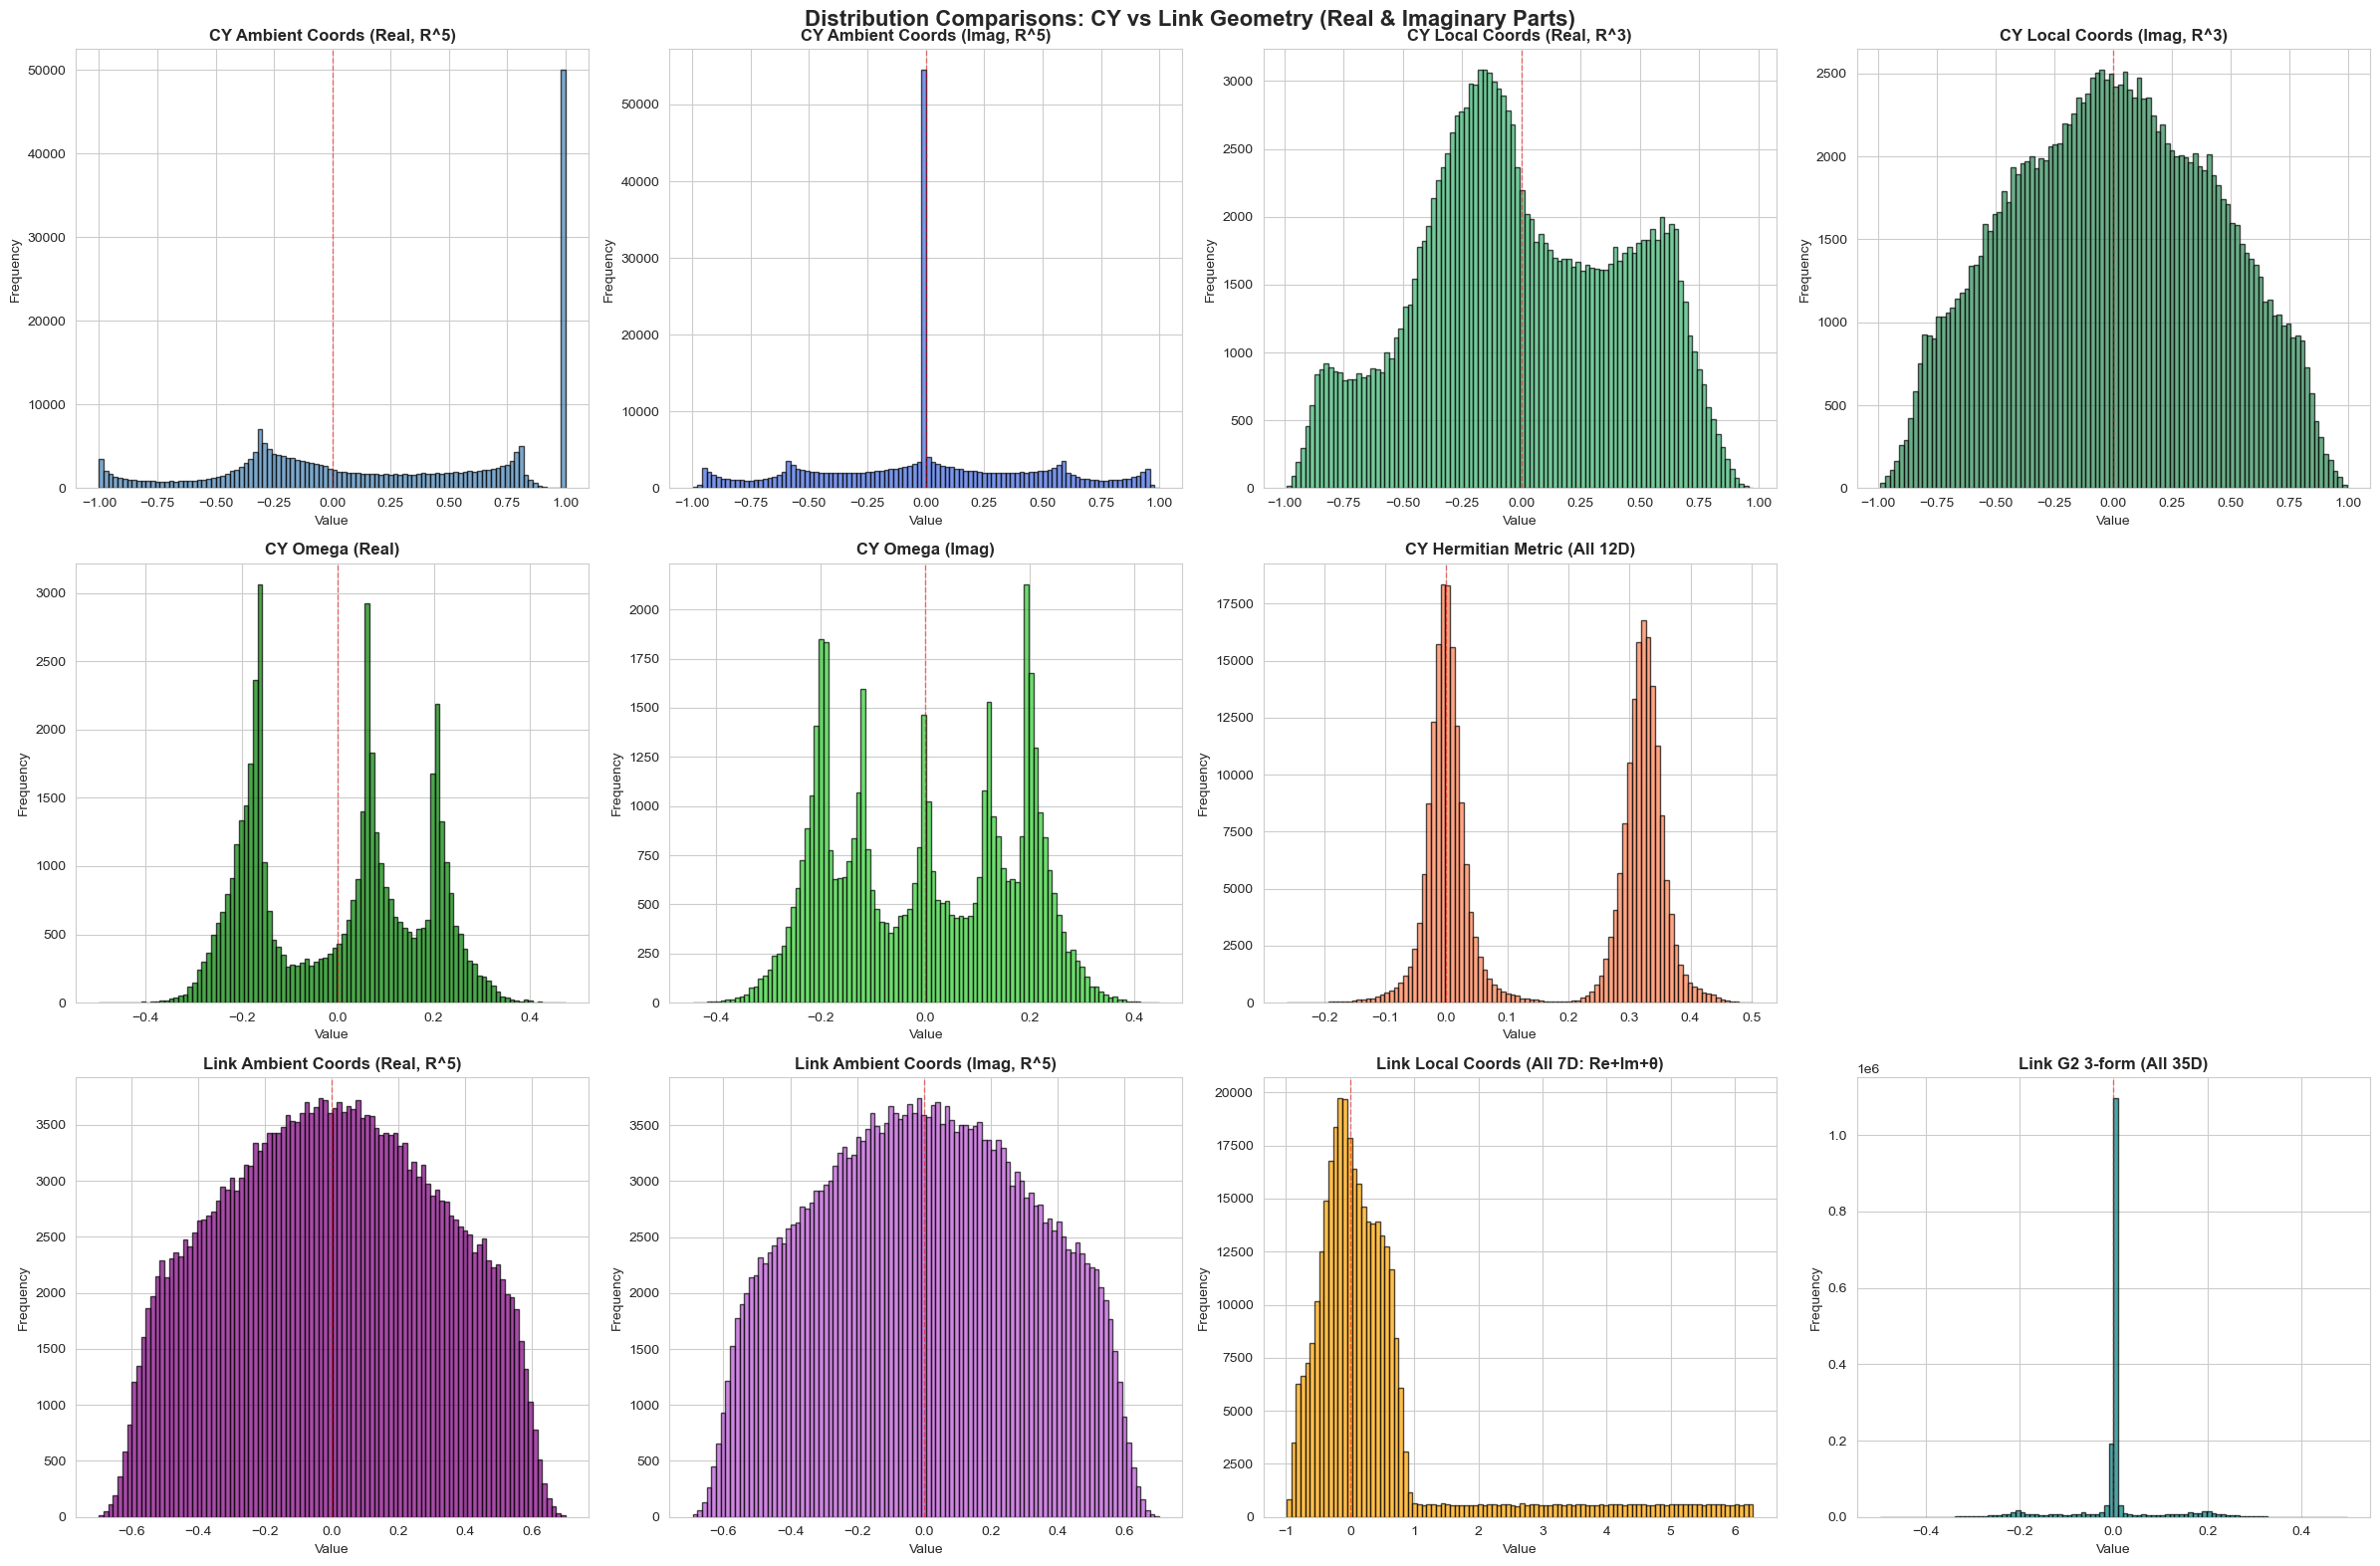

In [19]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

fig, axes = plt.subplots(3, 4, figsize=(24, 16))
fig.suptitle('Distribution Comparisons: CY vs Link Geometry (Real & Imaginary Parts)', fontsize=16, fontweight='bold')

# Row 1: CY ambient and local coordinates
axes[0, 0].hist(cy_coords_real.flatten(), bins=100, alpha=0.7, edgecolor='black', color='steelblue')
axes[0, 0].set_title('CY Ambient Coords (Real, R^5)', fontweight='bold')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[0, 1].hist(cy_coords_imag.flatten(), bins=100, alpha=0.7, edgecolor='black', color='royalblue')
axes[0, 1].set_title('CY Ambient Coords (Imag, R^5)', fontweight='bold')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[0, 2].hist(cy_local_real.flatten(), bins=100, alpha=0.7, edgecolor='black', color='mediumseagreen')
axes[0, 2].set_title('CY Local Coords (Real, R^3)', fontweight='bold')
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[0, 3].hist(cy_local_imag.flatten(), bins=100, alpha=0.7, edgecolor='black', color='seagreen')
axes[0, 3].set_title('CY Local Coords (Imag, R^3)', fontweight='bold')
axes[0, 3].set_xlabel('Value')
axes[0, 3].set_ylabel('Frequency')
axes[0, 3].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Row 2: CY omega and metric
axes[1, 0].hist(cy_omega_real.flatten(), bins=100, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].set_title('CY Omega (Real)', fontweight='bold')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[1, 1].hist(cy_omega_imag.flatten(), bins=100, alpha=0.7, edgecolor='black', color='limegreen')
axes[1, 1].set_title('CY Omega (Imag)', fontweight='bold')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[1, 2].hist(cy_g_vec.flatten(), bins=100, alpha=0.7, edgecolor='black', color='coral')
axes[1, 2].set_title('CY Hermitian Metric (All 12D)', fontweight='bold')
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Hide unused subplot
axes[1, 3].axis('off')

# Row 3: Link coordinates and G2 form
axes[2, 0].hist(link_coords_real.flatten(), bins=100, alpha=0.7, edgecolor='black', color='purple')
axes[2, 0].set_title('Link Ambient Coords (Real, R^5)', fontweight='bold')
axes[2, 0].set_xlabel('Value')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[2, 1].hist(link_coords_imag.flatten(), bins=100, alpha=0.7, edgecolor='black', color='mediumorchid')
axes[2, 1].set_title('Link Ambient Coords (Imag, R^5)', fontweight='bold')
axes[2, 1].set_xlabel('Value')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[2, 2].hist(link_local_coords.flatten(), bins=100, alpha=0.7, edgecolor='black', color='orange')
axes[2, 2].set_title('Link Local Coords (All 7D: Re+Im+θ)', fontweight='bold')
axes[2, 2].set_xlabel('Value')
axes[2, 2].set_ylabel('Frequency')
axes[2, 2].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

axes[2, 3].hist(link_phi_vec.flatten(), bins=100, alpha=0.7, edgecolor='black', color='teal')
axes[2, 3].set_title('Link G2 3-form (All 35D)', fontweight='bold')
axes[2, 3].set_xlabel('Value')
axes[2, 3].set_ylabel('Frequency')
#axes[2, 3].set_yscale('log')
axes[2, 3].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

## 9. Sparsity Analysis

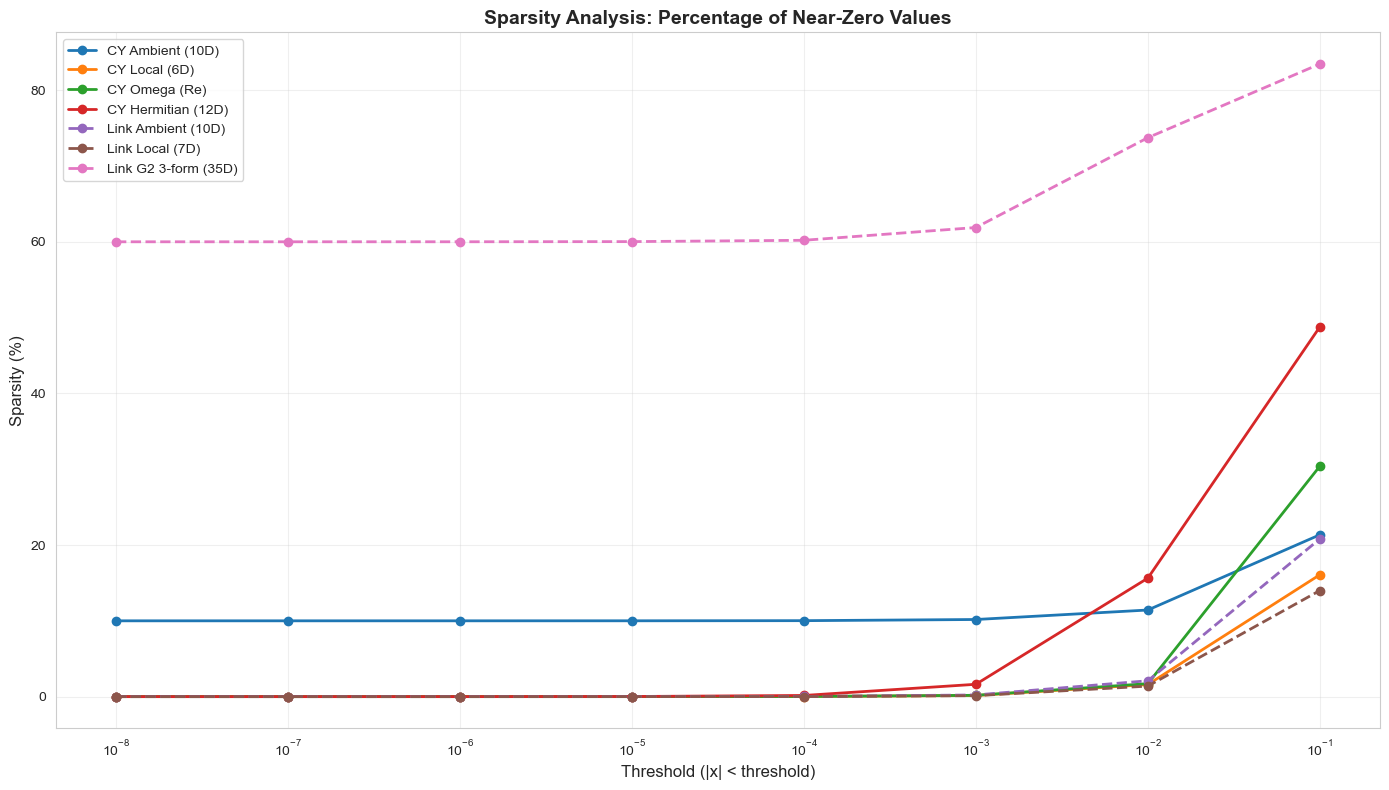

In [21]:
# Compute sparsity at different thresholds
thresholds = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

def sparsity_at_thresholds(data, name, thresholds):
    """Compute sparsity percentage at various thresholds."""
    sparsity_vals = []
    for thresh in thresholds:
        sparsity = np.sum(np.abs(data) < thresh) / data.size * 100
        sparsity_vals.append(sparsity)
    return sparsity_vals

# Combine real and imaginary parts for sparsity analysis
cy_coords_combined = np.concatenate([cy_coords_real, cy_coords_imag], axis=1)
cy_local_combined = np.concatenate([cy_local_real, cy_local_imag], axis=1)
link_coords_combined = np.concatenate([link_coords_real, link_coords_imag], axis=1)
link_local_combined = link_local_coords  # Already has real, imag, and theta

# Compute sparsity for all datasets
sparsity_data = {
    'CY Ambient (10D)': sparsity_at_thresholds(cy_coords_combined, 'CY Ambient', thresholds),
    'CY Local (6D)': sparsity_at_thresholds(cy_local_combined, 'CY Local', thresholds),
    'CY Omega (Re)': sparsity_at_thresholds(cy_omega_real, 'CY Omega Re', thresholds),
    'CY Hermitian (12D)': sparsity_at_thresholds(cy_g_vec, 'CY Hermitian', thresholds),
    'Link Ambient (10D)': sparsity_at_thresholds(link_coords_combined, 'Link Ambient', thresholds),
    'Link Local (7D)': sparsity_at_thresholds(link_local_combined, 'Link Local', thresholds),
    'Link G2 3-form (35D)': sparsity_at_thresholds(link_phi_vec, 'Link G2 3-form', thresholds),
}

if compute_g2_metric:
    sparsity_data['Link G2 Metric (28D)'] = sparsity_at_thresholds(link_g_vec, 'Link G2 Metric', thresholds)

# Plot sparsity curves
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
for name, sparsity_vals in sparsity_data.items():
    # Use dashed line style for Link geometry
    linestyle = '--' if name.startswith('Link') else '-'
    ax.plot(thresholds, sparsity_vals, marker='o', linewidth=2, linestyle=linestyle, label=name)

ax.set_xscale('log')
ax.set_xlabel('Threshold (|x| < threshold)', fontsize=12)
ax.set_ylabel('Sparsity (%)', fontsize=12)
ax.set_title('Sparsity Analysis: Percentage of Near-Zero Values', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Correlation Analysis

/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


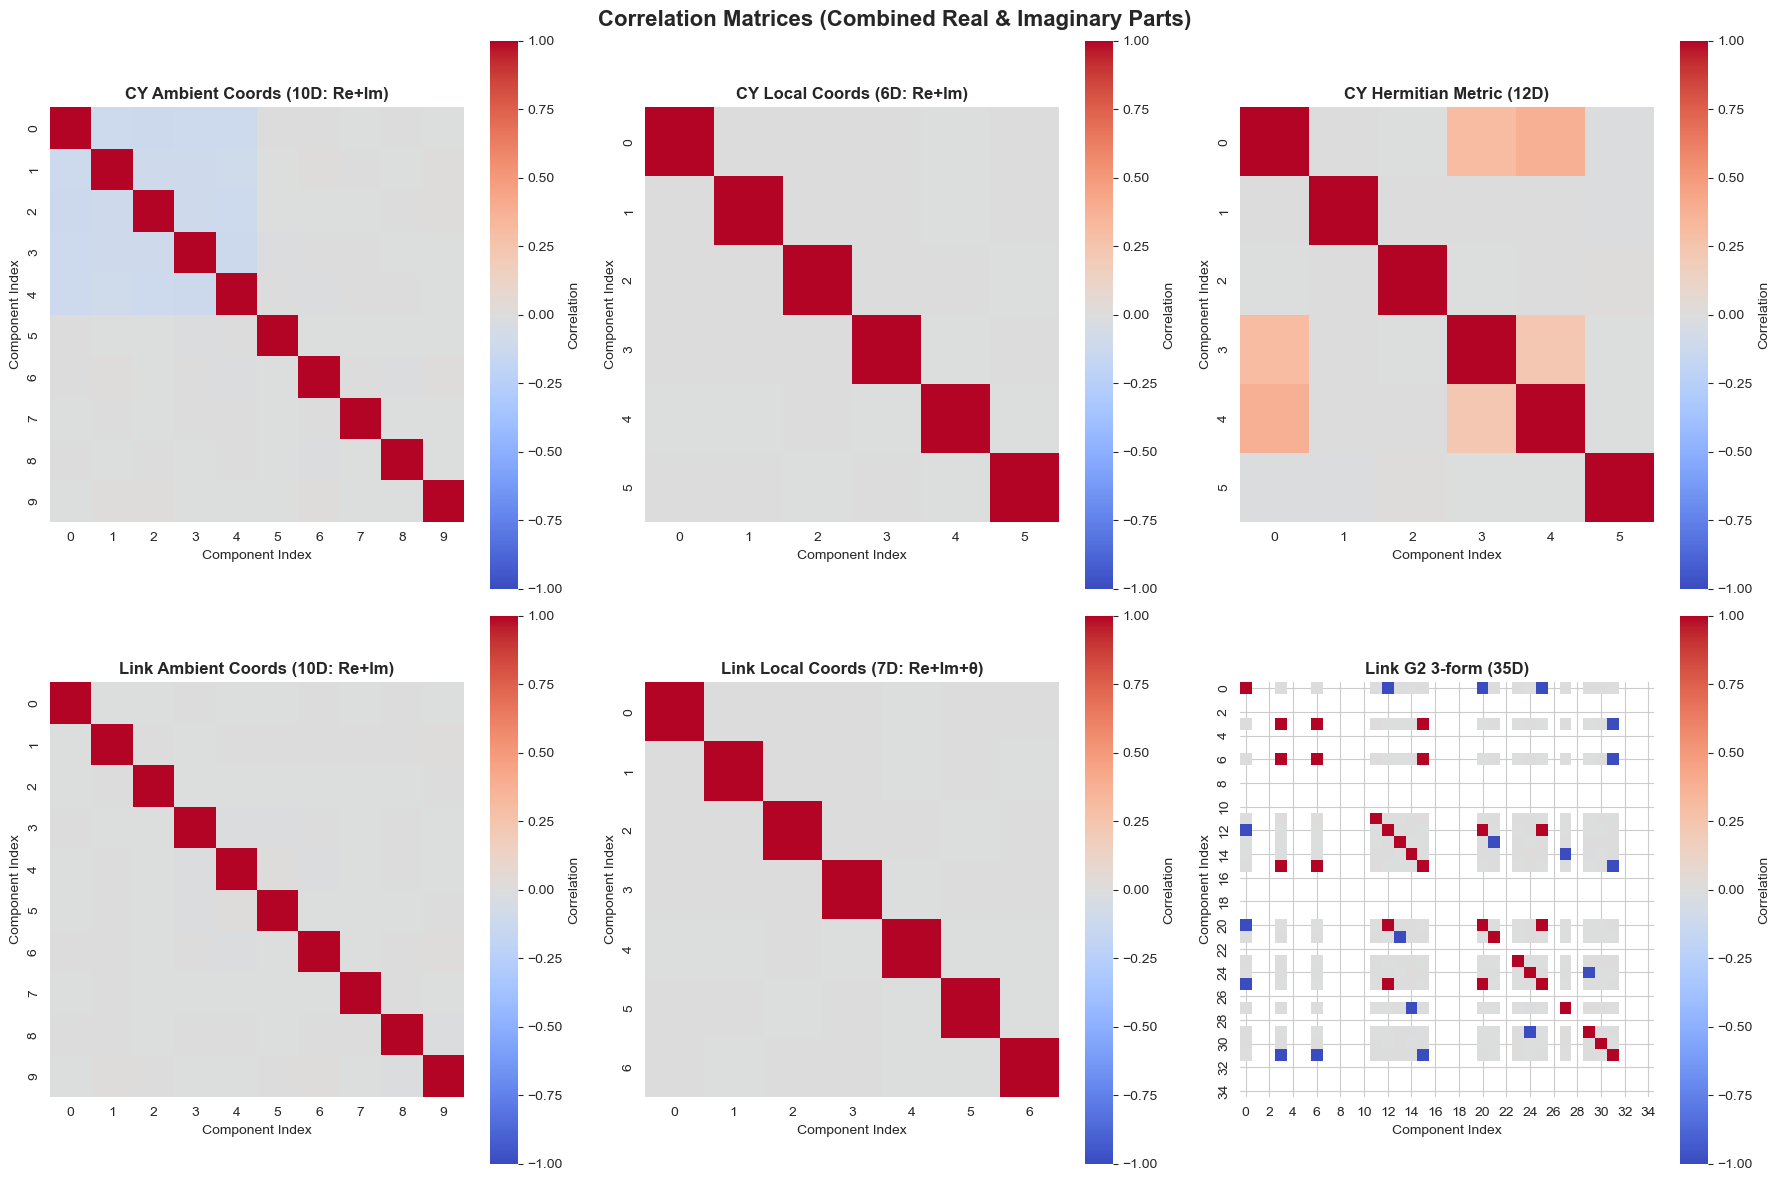

In [22]:
# Compute correlation matrices for combined coordinate systems
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Correlation Matrices (Combined Real & Imaginary Parts)', fontsize=16, fontweight='bold')

# CY Ambient Coordinates (10D: Real + Imag)
cy_coords_combined = np.concatenate([cy_coords_real, cy_coords_imag], axis=1)
cy_coords_combined_corr = np.corrcoef(cy_coords_combined.T)
sns.heatmap(cy_coords_combined_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            ax=axes[0, 0], square=True, cbar_kws={'label': 'Correlation'})
axes[0, 0].set_title('CY Ambient Coords (10D: Re+Im)', fontweight='bold')
axes[0, 0].set_xlabel('Component Index')
axes[0, 0].set_ylabel('Component Index')

# CY Local Coordinates (6D: Real + Imag)
cy_local_combined = np.concatenate([cy_local_real, cy_local_imag], axis=1)
cy_local_combined_corr = np.corrcoef(cy_local_combined.T)
sns.heatmap(cy_local_combined_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            ax=axes[0, 1], square=True, cbar_kws={'label': 'Correlation'})
axes[0, 1].set_title('CY Local Coords (6D: Re+Im)', fontweight='bold')
axes[0, 1].set_xlabel('Component Index')
axes[0, 1].set_ylabel('Component Index')

# CY Hermitian Metric (12D)
cy_g_corr = np.corrcoef(cy_g_vec.T)
sns.heatmap(cy_g_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            ax=axes[0, 2], square=True, cbar_kws={'label': 'Correlation'})
axes[0, 2].set_title('CY Hermitian Metric (12D)', fontweight='bold')
axes[0, 2].set_xlabel('Component Index')
axes[0, 2].set_ylabel('Component Index')

# Link Ambient Coordinates (10D: Real + Imag)
link_coords_combined = np.concatenate([link_coords_real, link_coords_imag], axis=1)
link_coords_combined_corr = np.corrcoef(link_coords_combined.T)
sns.heatmap(link_coords_combined_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            ax=axes[1, 0], square=True, cbar_kws={'label': 'Correlation'})
axes[1, 0].set_title('Link Ambient Coords (10D: Re+Im)', fontweight='bold')
axes[1, 0].set_xlabel('Component Index')
axes[1, 0].set_ylabel('Component Index')

# Link Local Coordinates (7D: Real + Imag + theta)
link_local_combined_corr = np.corrcoef(link_local_coords.T)
sns.heatmap(link_local_combined_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            ax=axes[1, 1], square=True, cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Link Local Coords (7D: Re+Im+θ)', fontweight='bold')
axes[1, 1].set_xlabel('Component Index')
axes[1, 1].set_ylabel('Component Index')

# Link G2 3-form (35D)
link_phi_corr = np.corrcoef(link_phi_vec.T)
sns.heatmap(link_phi_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            ax=axes[1, 2], square=True, cbar_kws={'label': 'Correlation'})
axes[1, 2].set_title('Link G2 3-form (35D)', fontweight='bold')
axes[1, 2].set_xlabel('Component Index')
axes[1, 2].set_ylabel('Component Index')

plt.tight_layout()
plt.show()

In [34]:
# Check proportion of NaN entries in link_phi_corr
nan_count = np.sum(np.isnan(link_phi_corr))
total_count = np.prod(link_phi_corr.shape)
nan_proportion = nan_count / total_count

print(f"Link G2 3-form correlation matrix:")
print(f"  Shape: {link_phi_corr.shape}")
print(f"  Total entries: {total_count}")
print(f"  NaN entries: {nan_count}")
print(f"  Proportion of NaN: {nan_proportion:.4f} ({nan_proportion*100:.2f}%)")

Link G2 3-form correlation matrix:
  Shape: (35, 35)
  Total entries: 1225
  NaN entries: 936
  Proportion of NaN: 0.7641 (76.41%)


## 11. Box Plots: Component-wise Distributions

/var/folders/8y/xbj0wv950wj7sk_j4l7301bw0000gn/T/ipykernel_14193/3299487381.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([cy_coords_combined[:, i] for i in range(cy_coords_combined.shape[1])],
/var/folders/8y/xbj0wv950wj7sk_j4l7301bw0000gn/T/ipykernel_14193/3299487381.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([cy_local_combined[:, i] for i in range(cy_local_combined.shape[1])],
/var/folders/8y/xbj0wv950wj7sk_j4l7301bw0000gn/T/ipykernel_14193/3299487381.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot([cy_g_vec[:, i] for i in range(cy_g_vec.

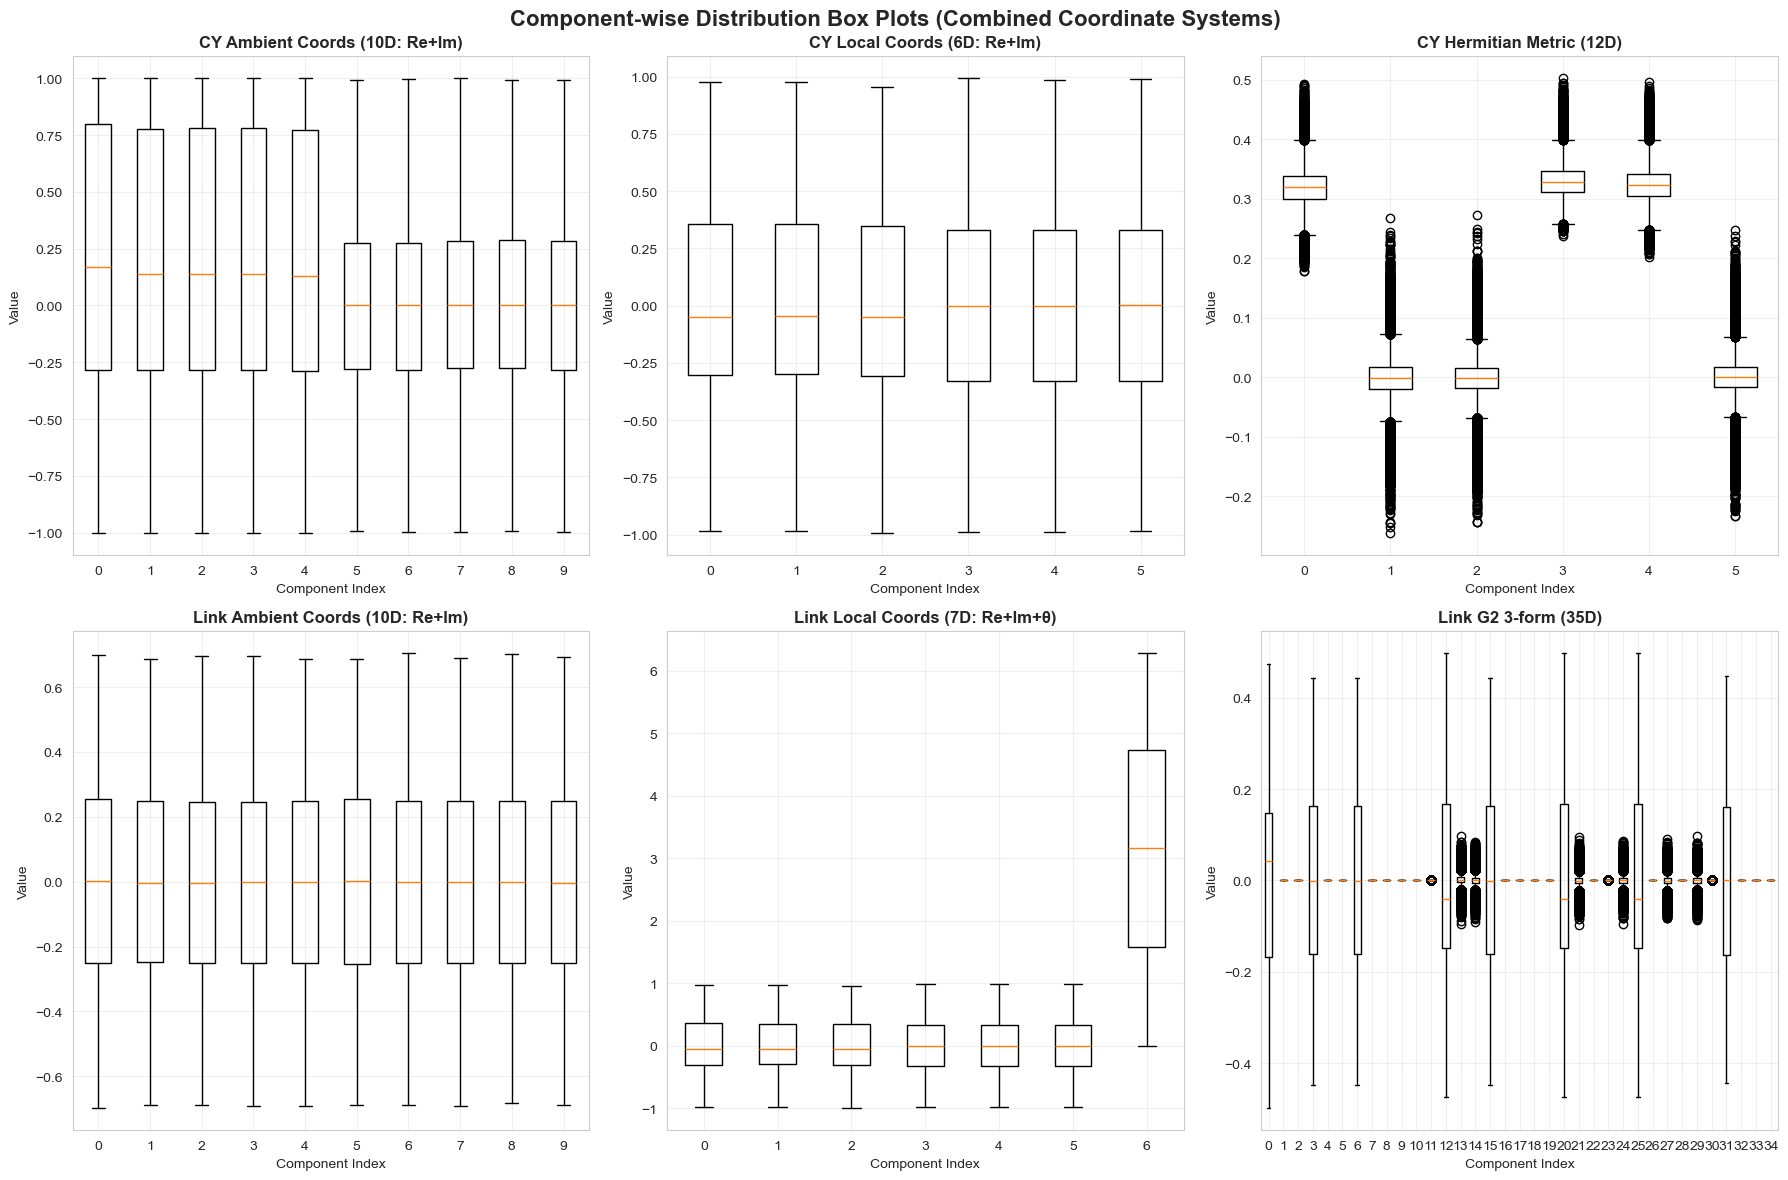

In [36]:
# Box plots for each dataset (using combined coordinate systems)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Component-wise Distribution Box Plots (Combined Coordinate Systems)', fontsize=16, fontweight='bold')

# Row 1: CY coordinates (combined), CY Hermitian metric, Link coordinates (combined)
axes[0, 0].boxplot([cy_coords_combined[:, i] for i in range(cy_coords_combined.shape[1])],
                    labels=range(cy_coords_combined.shape[1]))
axes[0, 0].set_title('CY Ambient Coords (10D: Re+Im)', fontweight='bold')
axes[0, 0].set_xlabel('Component Index')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot([cy_local_combined[:, i] for i in range(cy_local_combined.shape[1])],
                    labels=range(cy_local_combined.shape[1]))
axes[0, 1].set_title('CY Local Coords (6D: Re+Im)', fontweight='bold')
axes[0, 1].set_xlabel('Component Index')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].boxplot([cy_g_vec[:, i] for i in range(cy_g_vec.shape[1])],
                    labels=range(cy_g_vec.shape[1]))
axes[0, 2].set_title('CY Hermitian Metric (12D)', fontweight='bold')
axes[0, 2].set_xlabel('Component Index')
axes[0, 2].set_ylabel('Value')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Link coordinates
axes[1, 0].boxplot([link_coords_combined[:, i] for i in range(link_coords_combined.shape[1])],
                    labels=range(link_coords_combined.shape[1]))
axes[1, 0].set_title('Link Ambient Coords (10D: Re+Im)', fontweight='bold')
axes[1, 0].set_xlabel('Component Index')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot([link_local_coords[:, i] for i in range(link_local_coords.shape[1])],
                    labels=range(link_local_coords.shape[1]))
axes[1, 1].set_title('Link Local Coords (7D: Re+Im+θ)', fontweight='bold')
axes[1, 1].set_xlabel('Component Index')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].boxplot([link_phi_vec[:, i] for i in range(link_phi_vec.shape[1])],
                    labels=range(link_phi_vec.shape[1]))
axes[1, 2].set_title('Link G2 3-form (35D)', fontweight='bold')
axes[1, 2].set_xlabel('Component Index')
axes[1, 2].set_ylabel('Value')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Summary Comparison Table

In [15]:
# Create comprehensive comparison table
comparison_data = [
    stats_cy_coords_real,
    stats_cy_coords_imag,
    stats_cy_local_real,
    stats_cy_local_imag,
    stats_cy_omega_real,
    stats_cy_omega_imag,
    stats_cy_g,
    stats_link_coords_real,
    stats_link_coords_imag,
    stats_link_local_real,
    stats_link_local_imag,
    stats_link_theta,
    stats_link_phi,
]

if compute_g2_metric:
    comparison_data.append(stats_link_g)

comparison_df = pd.DataFrame([
    {
        'Dataset': d['name'],
        'Dim': d['shape'][1] if len(d['shape']) > 1 else 1,
        'Mean': f"{d['mean']:.4f}",
        'Std': f"{d['std']:.4f}",
        'Min': f"{d['min']:.4f}",
        'Max': f"{d['max']:.4f}",
        'Skew': f"{d['skewness']:.4f}",
        'Kurt': f"{d['kurtosis']:.4f}",
        'Sparsity': f"{d['sparsity']:.2f}%",
    }
    for d in comparison_data
])

print("\n" + "="*120)
print("COMPREHENSIVE COMPARISON: CY vs Link Geometry (Real & Imaginary Parts)")
print("="*120)
print(comparison_df.to_string(index=False))
print("="*120)

if not compute_g2_metric:
    print("\nNote: Link G2 Metric was not computed (compute_g2_metric=False)")


COMPREHENSIVE COMPARISON: CY vs Link Geometry (Real & Imaginary Parts)
                                   Dataset  Dim    Mean    Std     Min    Max    Skew    Kurt Sparsity
  CY Ambient Coords (Real part, C^5 → R^5)    5  0.1978 0.6028 -1.0000 1.0000 -0.1106 -1.1747    0.00%
  CY Ambient Coords (Imag part, C^5 → R^5)    5  0.0000 0.4506 -0.9973 0.9996  0.0004 -0.3592   20.00%
    CY Local Coords (Real part, C^3 → R^3)    3 -0.0034 0.4291 -0.9910 0.9780  0.0076 -0.8014    0.00%
    CY Local Coords (Imag part, C^3 → R^3)    3  0.0004 0.4299 -0.9892 0.9929 -0.0013 -0.8128    0.00%
                      CY Omega (Real part)    1  0.0005 0.1720 -0.4974 0.4745 -0.0063 -1.3033    0.00%
                      CY Omega (Imag part)    1  0.0005 0.1724 -0.4441 0.4475 -0.0049 -1.3043    0.01%
              CY Hermitian Metric (vector)    6  0.1618 0.1660 -0.2612 0.5024 -0.0100 -1.8204    0.00%
Link Ambient Coords (Real part, C^5 → R^5)    5 -0.0009 0.3160 -0.6967 0.7005  0.0036 -0.9502    0.00%
L